In [8]:

print("Begin init")
%run -i notebook/init_notebook.ipynb


import pandas as pd

from structlog import get_logger
from tqdm import tqdm


from lib.model.StockModel import StockModel
from lib.repository.FileOhlcRepository import FileOhlcRepository
from lib.repository.SymbolRepository import SymbolRepository
from lib.scrapper.YahooScrapper import YahooScrapper
from datetime import datetime, timedelta
print("Loading modules complete", datetime.now())

Begin init
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading modules complete 2021-05-05 15:03:25.418130


In [9]:
def _get_1min_data(symbol):
    from structlog import get_logger
    logger = get_logger()
    stop_date = datetime.utcnow()
    start_date = stop_date - timedelta(days=365)
    ohlc_repository = FileOhlcRepository("d:/proj/deep_dixi/_data/", logger)
    df_original = ohlc_repository.read_data("yahoo", symbol, start_date, stop_date)

    df_original = df_original[df_original['volume'] > 0]
    return df_original


stock = StockModel.parse("NASDAQ:MSFT")
min1_df = _get_1min_data(stock)
min1_df.describe()

,low,close,open,high,volume
count,75406.000000,75406.000000,75406.000000,75406.000000,7.540600e+04
mean,222.795352,222.898161,222.898428,222.999701,3.104025e+09
std,15.830188,15.823068,15.822772,15.815738,8.562049e+10
min,196.380000,196.470000,196.455000,196.670000,1.420000e+02
25%,210.921250,211.045250,211.050000,211.150000,3.107000e+04
50%,216.920000,217.029500,217.030000,217.125000,4.727600e+04
75%,233.731500,233.850000,233.860000,233.960000,7.585350e+04
max,262.950000,263.180000,263.190000,263.190000,5.425764e+12


In [20]:
from lib.calulation.BollingerBand import BollingerBand
from lib.calulation.PpoBuilder import PpoBuilder
import lib.calulation.utils as ta_utils

from lib.calulation.indicator_builder import build_indicatrors

rocs = [] # 2, 5, 10
property = 'close'
indicators = [
    # ta.VortexBuilder(14, rocs=rocs),
    # ta.VortexBuilder(24, rocs=rocs),
    # ta.VortexBuilder(32, rocs=rocs),
    #
    # ta.RsiBuilder(14, 8,  rocs=rocs),
    # ta.RsiBuilder(24, 8,  rocs=rocs),
    # ta.RsiBuilder(32, 8,  rocs=rocs),`

    # BollingerBand(property=property, n=14, rocs=rocs),
    # BollingerBand(property=property, n=24, rocs=rocs),
    # BollingerBand(property=property, n=32, rocs=rocs),

    PpoBuilder(slow=200, fast=10, smooth=5)
]

df = min1_df.copy()
basic_price = df.iloc[0].low
basic_volume = df.volume.min()
ta_utils.normilize_data_(df, basic_price, basic_volume)


min1_df_with_indicators = build_indicatrors(df, indicators)
min1_df_with_indicators = min1_df_with_indicators.iloc[1000:-1] # drop warmup

print(min1_df_with_indicators.iloc[-1].to_dict())
min1_df_with_indicators.describe()

738841324512.421 8467551320744.076
{'date': Timestamp('2021-05-05 18:44:00'), 'low': 1.1533311561071196, 'close': 1.153354483530839, 'open': 1.1534757861341793, 'high': 1.1536810674629094, 'volume': 7.133413598028697, "ppo(row:'close', fast:10, slow:200, k:5)": 0.009156544414402406}


,low,close,open,high,volume,"ppo(row:'close', fast:10, slow:200, k:5)"
count,74405.000000,74405.000000,74405.000000,74405.000000,74405.000000,74405.000000
mean,1.040326,1.040803,1.040803,1.041273,8.637934,0.001327
std,0.073931,0.073901,0.073900,0.073870,2.038441,0.379424
min,0.916208,0.916628,0.916558,0.917561,0.000000,-4.439810
25%,0.985210,0.985724,0.985724,0.986237,7.768557,-0.176596
50%,1.013810,1.014276,1.014276,1.014743,8.373631,0.005494
75%,1.091187,1.091770,1.091770,1.092283,9.055378,0.178771
max,1.226789,1.227862,1.227909,1.227909,35.153216,4.662355


<AxesSubplot:>

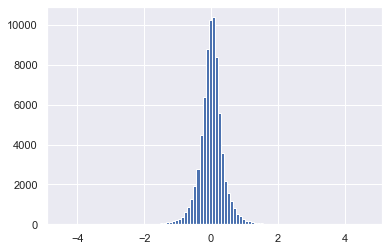

In [21]:
min1_df_with_indicators["ppo(row:'close', fast:10, slow:200, k:5)"].hist(bins=100)